In [32]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
from architecture.parameters.lstmParameters import LstmParameters
from architecture.simpleLSTMArchitecture import SimpleLSTMArchitecture
from system.lstmPreAndPostProcessor import LSTMPreAndPostProcessor
from system.lstmSystem import LSTMSystem
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops


In [8]:
import importlib
import system
importlib.reload(system.lstmSystem)
import architecture
importlib.reload(architecture.simpleLSTMArchitecture)
from architecture.simpleLSTMArchitecture import SimpleLSTMArchitecture
from system.lstmSystem import LSTMSystem

In [16]:
tf.reset_default_graph()
sessionsName = "nsynth2_"

batch_size = 64
params = LstmParameters(lstmSize=512, batchSize=batch_size, signalLength=5120, fftWindowLength=128, fftHopSize=32,
						countOfFrames=4)

aContextEncoderArchitecture = SimpleLSTMArchitecture(inputShape=(params.batchSize(),
																 params.fftFrames()-1,
																 params.fftFreqBins()), lstmParams=params)

aPreProcessor = LSTMPreAndPostProcessor(params)

aContextEncoderSystem = LSTMSystem(aContextEncoderArchitecture, batch_size, aPreProcessor, params, sessionsName)

In [3]:
pathToDatasetFolder = "nsynth-test/audio"
audios = StrechableNumpyArray()
i = 0
total = 0
file_names = []
for file_name in os.listdir(pathToDatasetFolder):
    audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None)

    if np.sum(np.absolute(audio[5120:5120*2])) < 5120*1e-3: 
        print(file_name, "doesn't meet the minimum amplitude requirement")
        continue

    file_names.append(file_name)
    audios.append(audio)
    i+=1

    if i > 500:
        i -= 500
        total += 500
        print("500 plus!", total)
        break
#         if total >= 0 and i >= 8:
#             break
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio)))
print(audios.shape)

bass_electronic_018-022-100.wav doesn't meet the minimum amplitude requirement
bass_electronic_018-023-025.wav doesn't meet the minimum amplitude requirement
bass_electronic_025-022-050.wav doesn't meet the minimum amplitude requirement
bass_electronic_027-022-050.wav doesn't meet the minimum amplitude requirement
500 plus! 500
there were:  501
(501, 64000)


In [82]:
tf_original_stft = tf.contrib.signal.stft(signals=audios[-1:, :16000], frame_length=params.fftWindowLength(), 
                                          frame_step=params.fftHopSize())

with tf.Session() as sess:
    magSpectrograms = sess.run(tf.abs(tf_original_stft))


In [83]:
magSpectrograms.shape


(1, 497, 65)

In [90]:
generatedSpecs = aContextEncoderSystem.generate(magSpectrograms, length=10000, model_num=134000)

INFO:tensorflow:Restoring parameters from utils/saved_models/nsynth2_/model-nsynth2_134000.ckpt
Model restored.


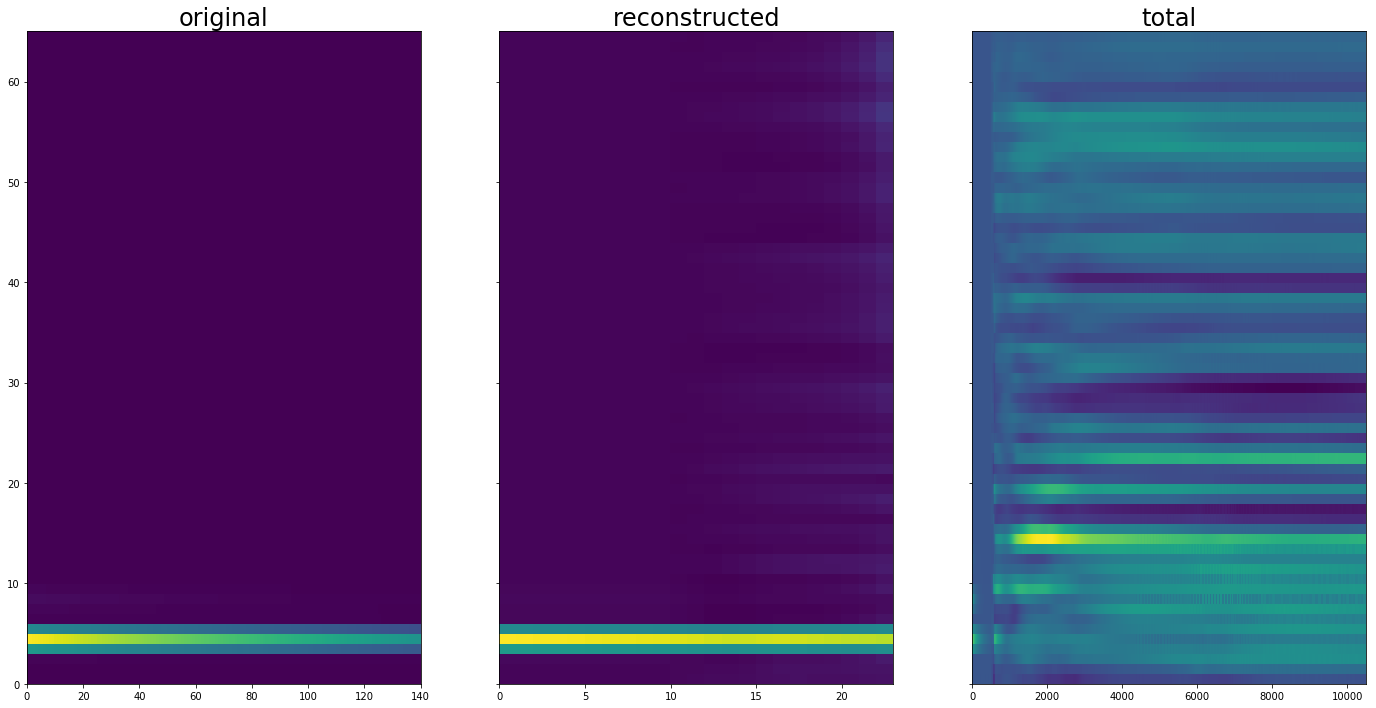

In [93]:
testOn = 0

f, axarr = plt.subplots(1, 3, sharey='row', figsize=(24, 12))

#scaleeee

axarr[0].pcolormesh(generatedSpecs[testOn, 357:497].transpose())
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(generatedSpecs[testOn, 487:510].transpose())
axarr[1].set_title('reconstructed', size=24)
axarr[2].pcolormesh(generatedSpecs[testOn, :].transpose())
axarr[2].set_title('total', size=24);

In [75]:
import copy
def griffinLim(realSignals, passes, params):
    absolute_values = copy.copy(realSignals)
    window_fn = functools.partial(window_ops.hann_window, periodic=True)
    inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                           forward_window_fn=window_fn)
    stft_to_invert = tf.placeholder(tf.complex64, shape=realSignals.shape, name='stft_to_invert')
    tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                              frame_step=params.fftHopSize(), window_fn=inverse_window)
    tf_forward_stft = tf.contrib.signal.stft(signals=tf_inverse_stft, frame_length=params.fftWindowLength(), 
                                          frame_step=params.fftHopSize(), window_fn=window_fn)
    with tf.Session() as sess:
        for i in range(passes):
#             realSignals = absolute_values + 1.0j*np.imag(realSignals)
            feed_dict = {stft_to_invert: realSignals}
            realSignals = sess.run(tf_forward_stft, feed_dict=feed_dict)
        feed_dict = {stft_to_invert: realSignals}
        return sess.run(tf_inverse_stft, feed_dict=feed_dict)


In [86]:
timeSignals = griffinLim(generatedSpecs, 30, params)

In [87]:
timeSignals.shape

(1, 48000)

In [88]:
IPython.display.Audio(data=timeSignals[0], rate=16000)